In [4]:
import chess
import chess.pgn
import chess.engine
import random
import time
from math import log,sqrt,e,inf

engine = chess.engine.SimpleEngine.popen_uci("stockfish")


class node:
    def __init__(self,*board):
        if(len(board)>0):
            self.state = board
        else:
            self.state = chess.Board()
        self.action = ''
        self.children = set()
        self.parent = None
        self.N = 0
        self.n = 0
        self.v = 0

def ucb1(curr_node):
    ans = curr_node.v+2*(sqrt(log(curr_node.N+e+(10**-6))/(curr_node.n+(10**-10))))
    return ans

def rollout(board,curr_node):
    
    if(curr_node.state.is_game_over()):
        board1 = curr_node.state
        if(board1.result()=='1-0'):
            #print("h1")
            return (1,curr_node)
        elif(board1.result()=='0-1'):
            #print("h2")
            return (-1,curr_node)
        else:
            return (0.5,curr_node)
    
    all_moves = [curr_node.state.san(i) for i in list(curr_node.state.legal_moves)]
    
    for i in all_moves:
        tmp_state = chess.Board(curr_node.state.fen())
        tmp_state.push_san(i)
        child = node(board)
        child.state = tmp_state
        child.parent = curr_node
        curr_node.children.add(child)
    rnd_state = random.choice(list(curr_node.children))

    return rollout(board,rnd_state)

def expand(curr_node,white):
    if(len(curr_node.children)==0):
        return curr_node
    max_ucb = -inf
    if(white):
        idx = -1
        max_ucb = -inf
        sel_child = None
        for i in curr_node.children:
            tmp = ucb1(i)
            if(tmp>max_ucb):
                idx = i
                max_ucb = tmp
                sel_child = i

        return(expand(sel_child,0))

    else:
        idx = -1
        min_ucb = inf
        sel_child = None
        for i in curr_node.children:
            tmp = ucb1(i)
            if(tmp<min_ucb):
                idx = i
                min_ucb = tmp
                sel_child = i

        return expand(sel_child,1)

def rollback(curr_node,reward):
    curr_node.n+=1
    curr_node.v+=reward
    while(curr_node.parent!=None):
        curr_node.N+=1
        curr_node = curr_node.parent
    return curr_node

def mcts_pred(board,curr_node,over,white,choice,iterations=10):
    if(over):
        return -1
    all_moves = [curr_node.state.san(i) for i in list(curr_node.state.legal_moves)]
    map_state_move = dict()
    
    for i in all_moves:
        tmp_state = chess.Board(curr_node.state.fen())
        tmp_state.push_san(i)
        child = node(board)
        child.state = tmp_state
        child.parent = curr_node
        curr_node.children.add(child)
        map_state_move[child] = i
        
    while(iterations>0):
        if(white):
            idx = -1
            max_ucb = -inf
            sel_child = None
            for i in curr_node.children:
                tmp = ucb1(i)
                if(tmp>max_ucb):
                    idx = i
                    max_ucb = tmp
                    sel_child = i
            ex_child = expand(sel_child,0)
            reward,state = rollout(board,ex_child)
            curr_node = rollback(state,reward)
            iterations-=1
        elif(choice==1):
            idx = -1
            min_ucb = inf
            sel_child = None
            for i in curr_node.children:
                tmp = ucb1(i)
                if(tmp<min_ucb):
                    idx = i
                    min_ucb = tmp
                    sel_child = i

            ex_child = expand(sel_child,1)

            reward,state = rollout(board,ex_child)

            curr_node = rollback(state,reward)
            iterations-=1
    if(white):
        
        mx = -inf
        idx = -1
        selected_move = ''
        for i in (curr_node.children):
            tmp = ucb1(i)
            if(tmp>mx):
                mx = tmp
                selected_move = map_state_move[i]
        return selected_move
    elif(choice==1):
        mn = inf
        idx = -1
        selected_move = ''
        for i in (curr_node.children):
            tmp = ucb1(i)
            if(tmp<mn):
                mn = tmp
                selected_move = map_state_move[i]
        return selected_move

#customizing problem size
#to randomize the starting position we can customize the board. for now I am using a random board setup
#board = chess.Board("r1bqkb1r/pppp1Qpp/2n2n2/4p3/2B1P3/8/PPPP1PPP/RNB1K1NR")
print("We want an input from you to arrange the board. We have randomized the pieces position with different numbers.Can you choose one from the following pieces you want in the board?")
s = input("p or P or Q or R or q or b . Only write the letter \n")
board = chess.Board("8/8/7"+s+"/8/8/r7/1kr5/7K")

#https://github.com/CSSLab/maia-chess/tree/master/move_prediction


#to let the pc choose random positions
#board = chess.Board.from_chess960_pos(random.randint(0, 959))
#board = chess.Board()
print(board)
choice=int(input("Do you want 1. AI-AI game or 2.Human-AI game? write 1 or 2= "))
if(choice==2):
    white=int(input("Do you want to play as 0.First player or 1.Second player? write 0 or 1= "))
else:
    white = 1
moves = 0
pgn = []
game = chess.pgn.Game()
evaluations = []
j=1
sm = 0
cnt = 0
evaluat = 0


while((not board.is_game_over())):
    all_moves = [board.san(i) for i in list(board.legal_moves)]
    start = time.time()
    if(white==1 or choice==1):
        root = node()
        root.state = board
        result = mcts_pred(board,root,board.is_game_over(),white,choice)
        print("time taken to iteration",j,(time.time()-start))
    elif(choice==2):
        print("input format should be something like a2, b6, g3, first one is row, second one is colum")
        print("row is a to h and colum is 1 to 8. if you are second player your pieces are small letter , otherwise capital")
        to=input("Write where you want to go = ")
        frm = input("write from where you want to move = ")
        result=frm+to
    try:
        board.push_san(result)
    except:
        print(result)
        print("invalid move. game over")
        break
    #print(result)
    pgn.append(result)
    white ^= 1
    j+=1
    
    moves+=1
    info = engine.analyse(board, chess.engine.Limit(depth=24))
    #evaluat += info['score'].white()
    print(board)
    print("-----------move done-----------")
#print(board)
print(" ".join(pgn))
print()
#print(evaluations)
print(board.result())
print(evaluat)
game.headers["Result"] = board.result()


We want an input from you to arrange the board. We have randomized the pieces position with different numbers.Can you choose one from the following pieces you want in the board?
p or P or Q or R or q or b . Only write the letter 
p
. . . . . . . .
. . . . . . . .
. . . . . . . p
. . . . . . . .
. . . . . . . .
r . . . . . . .
. k r . . . . .
. . . . . . . K
Do you want 1. AI-AI game or 2.Human-AI game? write 1 or 2= 1
time taken to iteration 1 0.6402308940887451
. . . . . . . .
. . . . . . . .
. . . . . . . p
. . . . . . . .
. . . . . . . .
r . . . . . . .
. k r . . . . .
. . . . . . K .
-----------move done-----------
time taken to iteration 2 0.76373291015625
. . . . . . . .
. . . . . . . .
. . . . . . . p
. . . . . . . .
. . . . . . . .
r . . . . . . .
k . r . . . . .
. . . . . . K .
-----------move done-----------
time taken to iteration 3 0.856086015701294
. . . . . . . .
. . . . . . . .
. . . . . . . p
. . . . . . . .
. . . . . . . .
r . . . . . . .
k . r . . . . .
. . . . . K . 

time taken to iteration 39 0.6401631832122803
. . . . . . . .
. . . . . r . .
. . . . . . . .
. K . . . . . p
. . . . . . . .
. . . . . . . .
k . . . . . . .
. . . . . . . .
-----------move done-----------
time taken to iteration 40 0.7274699211120605
. . . . . . . .
. . . . . . . .
. . . . . . . .
. K . . . . . p
. . . . . . . .
. . . . . . . .
k . . . . r . .
. . . . . . . .
-----------move done-----------
time taken to iteration 41 0.5031900405883789
. . . . . . . .
. . . . . . . .
. K . . . . . .
. . . . . . . p
. . . . . . . .
. . . . . . . .
k . . . . r . .
. . . . . . . .
-----------move done-----------
time taken to iteration 42 0.677283763885498
. . . . . . . .
. . . . . . . .
. K . . . . . .
. . . . . . . p
. . . . . . . .
. . . . . . . .
k . . . . . r .
. . . . . . . .
-----------move done-----------
time taken to iteration 43 0.9519269466400146
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . K . . . . p
. . . . . . . .
. . . . . . . .
k . . . . . r .
. . . . . . . .
---

time taken to iteration 79 0.7630000114440918
K . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . p
. . . . . . . .
k . . . . . . .
. r . . . . . .
. . . . . . . .
-----------move done-----------
time taken to iteration 80 0.6031289100646973
K . . . . . . .
. . . . . . . .
. r . . . . . .
. . . . . . . p
. . . . . . . .
k . . . . . . .
. . . . . . . .
. . . . . . . .
-----------move done-----------
time taken to iteration 81 0.6282320022583008
. . . . . . . .
K . . . . . . .
. r . . . . . .
. . . . . . . p
. . . . . . . .
k . . . . . . .
. . . . . . . .
. . . . . . . .
-----------move done-----------
time taken to iteration 82 0.558150053024292
. . . . . . . .
K . . . . . . .
. r . . . . . .
. . . . . . . p
. . . . . . . .
. . . . . . . .
. k . . . . . .
. . . . . . . .
-----------move done-----------
time taken to iteration 83 0.3789992332458496
K . . . . . . .
. . . . . . . .
. r . . . . . .
. . . . . . . p
. . . . . . . .
. . . . . . . .
. k . . . . . .
. . . . . . . .
---

time taken to iteration 119 0.2559831142425537
. . . . k . . .
. . . . . . . .
. . . . . . . .
. . . . . K . .
. . . . . . . .
. . . . . . . p
. . . . . . . .
. . . . . . . .
-----------move done-----------
time taken to iteration 120 0.08551907539367676
. . . . . . . .
. . . . . k . .
. . . . . . . .
. . . . . K . .
. . . . . . . .
. . . . . . . p
. . . . . . . .
. . . . . . . .
-----------move done-----------
time taken to iteration 121 0.18758296966552734
. . . . . . . .
. . . . . k . .
. . . . . . . .
. . . . . . . .
. . . . . . K .
. . . . . . . p
. . . . . . . .
. . . . . . . .
-----------move done-----------
time taken to iteration 122 0.2983591556549072
. . . . k . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . K .
. . . . . . . p
. . . . . . . .
. . . . . . . .
-----------move done-----------
time taken to iteration 123 0.20653986930847168
. . . . k . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . K . .
. . . . . . . p
. . . . . . . .
. . . . . 

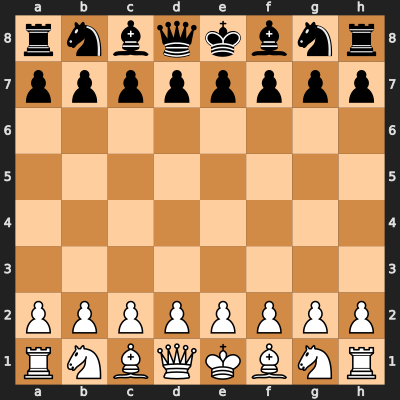

In [5]:
import chess
import chess.svg

from IPython.display import SVG

board = chess.Board()
SVG(chess.svg.board(board=board,size=400))


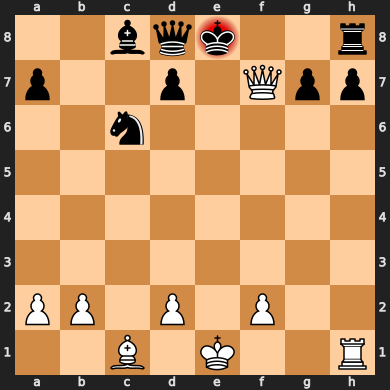

In [6]:
import chess
import chess.pgn
import chess.engine
import random
import time
from math import log,sqrt,e,inf
board = chess.Board("2bqk2r/p2p1Qpp/2n5/8/8/8/PP1P1P2/2B1K2R b Kk - 0 0")
board